## Custom Model Training for Emotion, Age, and Gender Classification

The purpose of this notebook is to perform custom training of three binary classification models using TensorFlow and Keras.

*  **Emotion model**: This model is used to classify between happy vs sad. It is trained on a subset of the FER-2013 dataset, using only the happy and sad classes. It uses a custom CNN model with greyscale 48x48 images. It is designed to be compact for later deployment for mobile/web environments.
* **Age model**: This model is designed for binary classification between adults and elderly. It is trained on the UTKFace dataset with (age < 50 → Adult, ≥ 50 → Elderly). It uses  a MobileNetV2-based binary classifier on resized 224×224 RGB images.
*   **Gender model:** This model is designed for binary classification between male and female. It is trained on the UTKFace dataset, using using MobileNetV2 in the same way as the age model.
*   The trained models will be saved as .h5 files, and will be converted to TF.js or TFLite in the next phase.


**1. Setting up the environment**

In [ ]:
!pip install \
  numpy==1.25.2 \
  tensorflow==2.15.0 \
  keras==2.15.0 \
  protobuf==4.25.3 \
  wrapt==1.14.1 \
  ml-dtypes==0.2.0 \
  tensorflow-estimator==2.15.0 \
  tensorboard==2.15.1 \
  --no-deps --force-reinstall

In [ ]:
import numpy as np
import tensorflow as tf
import keras
print("GPU available:", tf.config.list_physical_devices('GPU'))

print("✅ NumPy:", np.__version__)
print("✅ TensorFlow:", tf.__version__)
print("✅ Keras:", keras.__version__)

GPU available: []
✅ NumPy: 1.25.2
✅ TensorFlow: 2.15.0
✅ Keras: 2.15.0


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from IPython.display import display
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import kagglehub

# Download latest version FER-2013
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
!ls /kaggle/input/fer2013/


test  train


In [ ]:
# Download latest version UTKFace
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
DRIVE_PATH = "/content/drive/MyDrive/Edge_AI_Project"
MODEL_PATH = os.path.join(DRIVE_PATH, "models/saved_models")
LOG_PATH = os.path.join(DRIVE_PATH, "models/logs")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)
utkface_dir = "/kaggle/input/utkface-new/UTKFace"
emotion_train_dir = "/kaggle/input/fer2013/train"
emotion_test_dir = "/kaggle/input/fer2013/test"

**2. Training the models**

The training function has been designed to find a balance between accuracy and avoiding RAM usage crashes.
We will use a low batch size of 8. The models are trained using 10 epochs. This increases training time, but does increase accuray with minimal impact on RAM usage.
The trained models for age, gender and emotion will be saved with performance metrics logged.
After training each model, the session will be cleared before the next model is trained.

In [ ]:
# Load UTKFace subset
def load_utkface_subset(data_dir, task='age', max_samples=2000):
    data = []
    count = 0
    for file in os.listdir(data_dir):
        if file.endswith('.jpg'):
            parts = file.split('_')
            if len(parts) < 2: continue
            age = int(parts[0])
            gender = int(parts[1])
            img = cv2.imread(os.path.join(data_dir, file))
            if img is None: continue
            img = cv2.resize(img, (224, 224))
            label = 0 if (task == 'age' and age < 50) else 1 if task == 'age' else gender
            data.append((img, label))
            count += 1
            if count >= max_samples: break
    X, y = zip(*data)
    return np.array(X).astype('float32') / 255.0, np.array(y)

def prepare_data(X, y):
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def build_mobilenet_classifier():
    base = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=x)

In [ ]:
# Setting up the training and logging function with callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_and_log(model, X_train, y_train, X_val, y_val, name, epochs=100):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, f"{name}_best.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    earlystop_cb = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    if y_train is None and y_val is None:
        # If using generators
        history = model.fit(
            X_train,
            validation_data=X_val,
            epochs=epochs,
            callbacks=[checkpoint_cb, earlystop_cb]
        )
    else:
        # If using arrays (age/gender)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=[checkpoint_cb, earlystop_cb]
        )

    model.save(os.path.join(MODEL_PATH, f"{name}.h5"))
    print(f"✅ Saved {name}.h5")

    hist_df = pd.DataFrame(history.history)
    hist_df.index.name = 'epoch'
    hist_df.to_csv(os.path.join(LOG_PATH, f"{name}_log.csv"))
    print(f"✅ Saved {name}_log.csv")

    K.clear_session()
    return history

**3. Training the Emotion model**

The emotion model is designed for binary classification between happy and sad. The original FER2013 dataset contains data for 7 emotions, but we will use only the "happy" and "sad" subfolders to train the model.

In [ ]:
# Build emotion model
def build_emotion_model():
    inputs = Input(shape=(48, 48, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

In [ ]:
import os
import shutil

# Source paths
source_train = "/kaggle/input/fer2013/train"
source_test = "/kaggle/input/fer2013/test"

# Target paths
target_train = "/content/emotion_binary/train"
target_test = "/content/emotion_binary/test"

# Emotion folders to keep
target_classes = ['happy', 'sad']

for cls in target_classes:
    os.makedirs(os.path.join(target_train, cls), exist_ok=True)
    os.makedirs(os.path.join(target_test, cls), exist_ok=True)

    # Copy training images
    src_cls_train = os.path.join(source_train, cls)
    tgt_cls_train = os.path.join(target_train, cls)
    for fname in os.listdir(src_cls_train):
        shutil.copy(os.path.join(src_cls_train, fname), os.path.join(tgt_cls_train, fname))

    # Copy test images
    src_cls_test = os.path.join(source_test, cls)
    tgt_cls_test = os.path.join(target_test, cls)
    for fname in os.listdir(src_cls_test):
        shutil.copy(os.path.join(src_cls_test, fname), os.path.join(tgt_cls_test, fname))

print("✅ Filtered dataset created at /content/emotion_binary")

✅ Filtered dataset created at /content/emotion_binary


In [ ]:
emotion_train_dir = "/content/emotion_binary/train"
emotion_test_dir = "/content/emotion_binary/test"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

emotion_datagen = ImageDataGenerator(rescale=1./255)

emotion_generator = emotion_datagen.flow_from_directory(
    emotion_train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

print("Emotion class indices:", emotion_generator.class_indices)


Found 12045 images belonging to 2 classes.
Emotion class indices: {'happy': 0, 'sad': 1}


In [ ]:
# Train Emotion Model
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(emotion_train_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=32, shuffle=True)
test_generator = datagen.flow_from_directory(emotion_test_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=32, shuffle=False)

emotion_model = build_emotion_model()
emotion_history = train_and_log(
    emotion_model,
    train_generator,
    None,  # y_train not needed for generators
    test_generator,
    None,  # y_val not needed for generators
    name='emotion_model'
)

Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.
Epoch 1/100
377/377 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6788
Epoch 1: val_accuracy improved from -inf to 0.42833, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/emotion_model_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - 115s 302ms/step - loss: 0.7292 - accuracy: 0.6788 - val_loss: 14.0231 - val_accuracy: 0.4283
Epoch 2/100
377/377 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.7592
Epoch 2: val_accuracy improved from 0.42833 to 0.68421, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/emotion_model_best.h5
377/377 [==============================] - 115s 306ms/step - loss: 0.4962 - accuracy: 0.7592 - val_loss: 0.5700 - val_accuracy: 0.6842
Epoch 3/100
377/377 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.7908
Epoch 3: val_accuracy improved from 0.68421 to 0.77954, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/emotion_model_best.h5
377/377 [==============================] - 112s 298ms/step - loss: 0.4209 - accuracy: 0.7908 - val_loss: 0.4442 - val_accuracy: 0.7795
Epoch 4/100
377/377 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.82

In [ ]:
import os

emotion_model_path = os.path.join(MODEL_PATH, "emotion_model.h5")
emotion_log_path = os.path.join(LOG_PATH, "emotion_model_log.csv")

# Check existence
model_exists = os.path.exists(emotion_model_path)
log_exists = os.path.exists(emotion_log_path)

print("✅ Emotion model file saved:" if model_exists else "❌ Emotion model file NOT found")
print("✅ Emotion log file saved:" if log_exists else "❌ Emotion log file NOT found")


✅ Emotion model file saved:
✅ Emotion log file saved:


**4. Training the age and gender models**

In [ ]:
# Load and prepare data for Age model
X_age, y_age = load_utkface_subset(utkface_dir, task='age', max_samples=2000)
X_train, X_val, y_train, y_val = prepare_data(X_age, y_age)

# Train Age Model
age_model = build_mobilenet_classifier()
age_history = train_and_log(age_model, X_train, y_train, X_val, y_val, name='age_model')


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8419
Epoch 1: val_accuracy improved from -inf to 0.77750, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/age_model_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 263s 5s/step - loss: 0.3916 - accuracy: 0.8419 - val_loss: 3.9221 - val_accuracy: 0.7775
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9137
Epoch 2: val_accuracy did not improve from 0.77750
50/50 [==============================] - 251s 5s/step - loss: 0.2190 - accuracy: 0.9137 - val_loss: 3.3184 - val_accuracy: 0.7775
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9375
Epoch 3: val_accuracy did not improve from 0.77750
50/50 [==============================] - 241s 5s/step - loss: 0.1712 - accuracy: 0.9375 - val_loss: 4.4522 - val_accuracy: 0.7775
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9494
Epoch 4: val_accuracy improved from 0.77750 to 0.78000, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/age_model_best.h5
50/50 [==============================] - 241s 5s/step - loss: 0.1245 - acc

In [ ]:
# Load and prepare data for Gender model
X_gender, y_gender = load_utkface_subset(utkface_dir, task='gender', max_samples=2000)
X_train, X_val, y_train, y_val = prepare_data(X_gender, y_gender)

# Train Gender Model
gender_model = build_mobilenet_classifier()
gender_history = train_and_log(gender_model, X_train, y_train, X_val, y_val, name='gender_model')


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7731
Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/gender_model_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 255s 5s/step - loss: 0.5065 - accuracy: 0.7731 - val_loss: 1.5164 - val_accuracy: 0.6500
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8731
Epoch 2: val_accuracy did not improve from 0.65000
50/50 [==============================] - 239s 5s/step - loss: 0.2945 - accuracy: 0.8731 - val_loss: 0.9980 - val_accuracy: 0.6375
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9200
Epoch 3: val_accuracy improved from 0.65000 to 0.66000, saving model to /content/drive/MyDrive/Edge_AI_Project/models/saved_models/gender_model_best.h5
50/50 [==============================] - 254s 5s/step - loss: 0.2069 - accuracy: 0.9200 - val_loss: 3.3795 - val_accuracy: 0.6600
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9375
Epoch 4: val_accuracy improved from 0.66000 to 0.75750, saving model to /content/drive/MyDrive/Edge_AI_Project/models/save

**5. Performance metrics**

In [ ]:
# Print final performance summary table
summary = []

for name in ["age_model", "gender_model", "emotion_model"]:
    log_path = os.path.join(LOG_PATH, f"{name}_log.csv")
    if os.path.exists(log_path):
        df = pd.read_csv(log_path)

        # Find the epoch with best validation accuracy
        best_idx = df['val_accuracy'].idxmax()
        best_row = df.iloc[best_idx]

        summary.append({
            "Model": name.replace("_model", "").capitalize(),
            "Best Val Acc": round(best_row['val_accuracy'], 4),
            "Train Acc": round(best_row['accuracy'], 4),
            "Val Loss": round(best_row['val_loss'], 4),
            "Epoch": best_idx + 1  # to match 1-based display
        })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Model,Best Val Acc,Train Acc,Val Loss,Epoch
0,Age,0.8450,0.9781,1.0503,8
1,Gender,0.7600,0.9638,1.0620,7
2,Emotion,0.8163,0.9461,0.6417,9


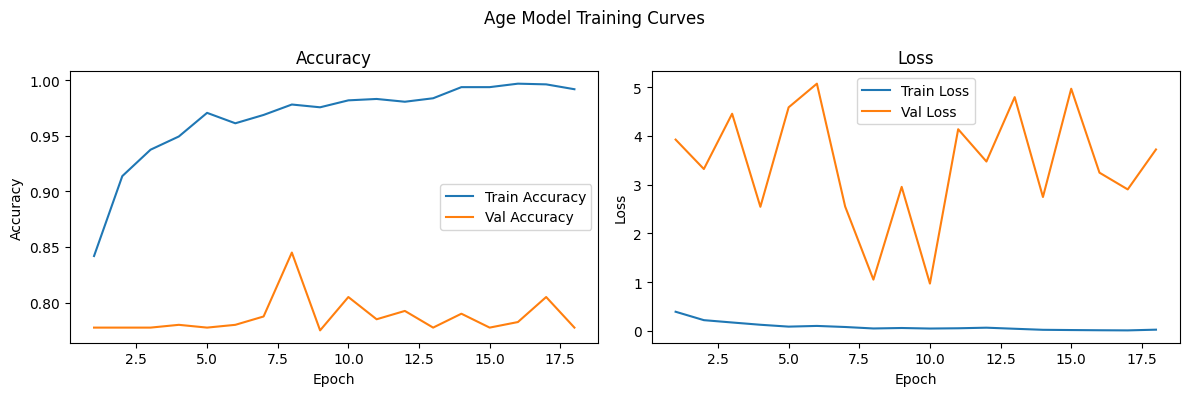

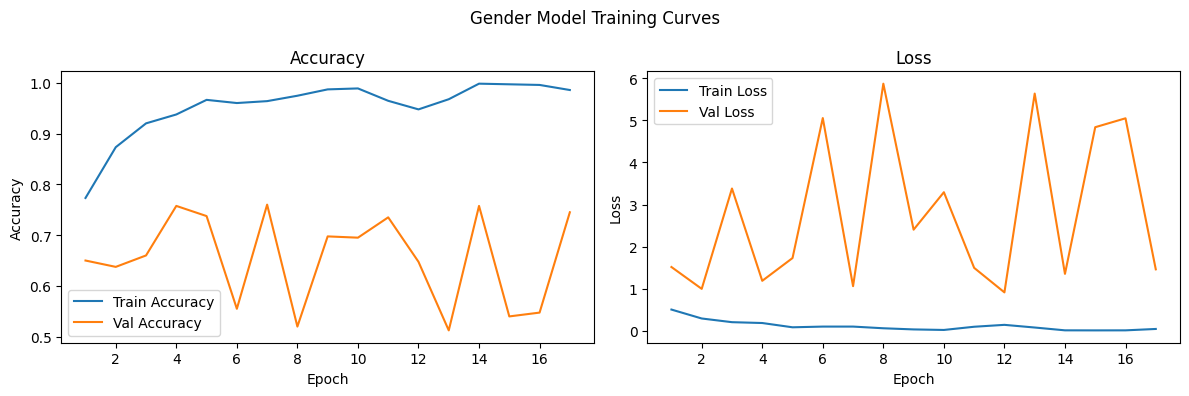

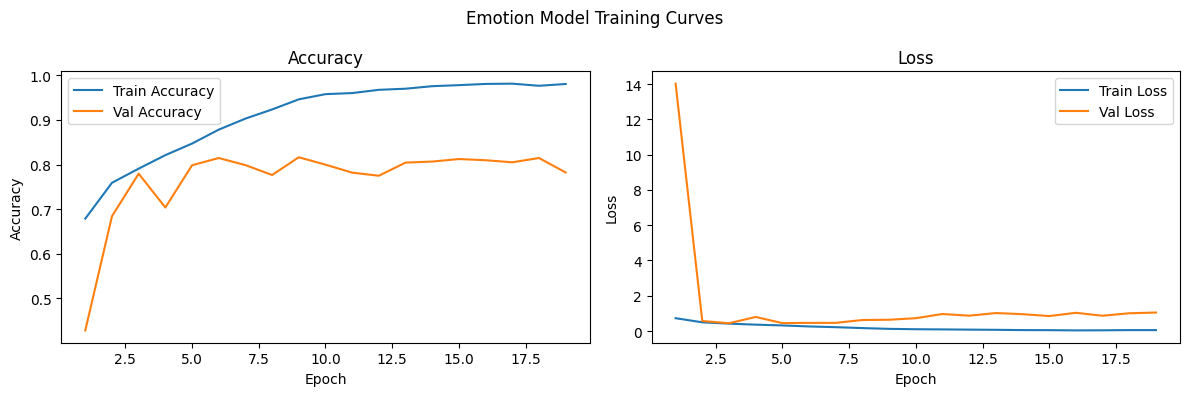

In [ ]:
# Plot training and validation curves
import matplotlib.pyplot as plt

def plot_history(log_path, title):
    if not os.path.exists(log_path):
        print(f"❌ Log not found for {title}")
        return
    df = pd.read_csv(log_path)
    epochs = df.index + 1

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{title} Model Training Curves')

    ax[0].plot(epochs, df['accuracy'], label='Train Accuracy')
    ax[0].plot(epochs, df['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, df['loss'], label='Train Loss')
    ax[1].plot(epochs, df['val_loss'], label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Plot for each model
for name in ["age_model", "gender_model", "emotion_model"]:
    plot_history(os.path.join(LOG_PATH, f"{name}_log.csv"), name.replace("_model", "").capitalize())
